## 投票分类器
todo2：补笔记

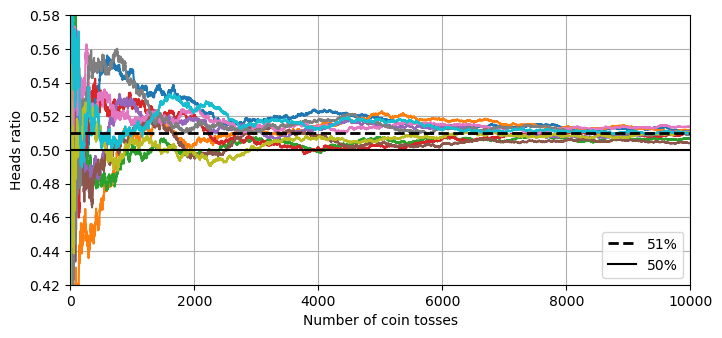

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from nltk import extract

heads_proba = 0.51
np.random.seed(42)
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
cumulative_heads = coin_tosses.cumsum(axis=0)
cumulative_heads_ratio = cumulative_heads / np.arange(1, 10001).reshape(-1, 1)

plt.figure(figsize=(8, 3.5))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])
plt.grid()
plt.show()

todo：补笔记

当预测器尽可能互相独立时，集成方法的效果最优。获得多种分类器的方法之一就是使用不同的算法进行训练。这会增加它们犯不同类型错误的机会，从而提升集成的精度。

In [3]:
from sklearn.datasets import make_moons
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', LogisticRegression(random_state=42)),
                ('rf', RandomForestClassifier(random_state=42)),
                ('svc', SVC(random_state=42))]
)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

当拟合VotingClassifier时，它会克隆每个估计器并拟合这个克隆。

原始估计器可通过estimators属性获得，而拟合克隆可通过estimators_属性获得。

如果更喜欢字典而不是列表，则可以改用named_estimators或named_estimators_。

首先，看看每个拟合分类器在测试集上的精度：

In [4]:
for name, clf in voting_clf.named_estimators_.items():
    print(name, "=", clf.score(X_test, y_test))

lr = 0.864
rf = 0.896
svc = 0.896


当调用投票分类器的predict()方法时，它会执行硬投票。

例如，投票分类器为测试集的第一个实例预测类1，因为三个分类器中有两个预测了该类：

In [5]:
voting_clf.predict(X_test[:1])
[clf.predict(X_test[:1]) for clf in voting_clf.estimators_]

[array([1], dtype=int64), array([1], dtype=int64), array([0], dtype=int64)]

In [6]:
# 投票分类器在测试集上的表现
voting_clf.score(X_test, y_test)  # 投票分类器优于单个分类器

0.912

如果所有分类器都能够估计类概率［即如果它们都有一个predict_proba()方法］，

那么可以告诉Scikit-Learn预测具有最高类概率的类，对所有单独的分类器进行平均。这称为软投票。

它通常比硬投票能获得更高的性能，因为它给高度自信的投票更多的权重。需要做的就是将投票分类器的投票超参数设置为"soft"，并确保所有分类器都可以估计类概率。默认情况下SVC类不是这种情况，因此需要将其probability超参数设置为True［这会使SVC类使用交叉验证来估计类概率，减慢训练速度，并且它会添加一个predict_proba()方法］。

In [7]:
voting_clf.voting
voting_clf.voting = "soft"
voting_clf.named_estimators["svc"].probability = True # 原始估计器修改属性
voting_clf.fit(X_train, y_train)
voting_clf.score(X_test, y_test)  # 软投票又提高了性能

0.92

## bagging和pasting

前面提到，获得不同种类分类器的方法之一是使用不同的训练算法。

还有另一种方法是每个预测器使用的算法相同，但是在不同的训练集随机子集上进行训练。

采样时如果将样本放回，这种方法叫作bagging(bootstrap aggregating的缩写)

采样时样本不放回，这种方法则叫pasting。

换句话说，bagging和pasting都允许训练实例在多个预测器中被多次采样，但是只有bagging允许训练实例被同一个预测器多次采样。采样过程和训练过程如图所示：

![在训练集的不同随机样本上训练几个预测其](./images/random_forest/p1.png)

一旦预测器训练完成，集成就可以通过简单地聚合所有预测器的预测，来对新实例做出预测。

聚合函数通常是分类的统计模式（即最多数的预测就像硬投票分类器），或是平均法用于回归。

每个预测器单独的偏差都高于在原始训练集上训练的偏差，但是聚合可以同时降低偏差和方差。

总体来说，最终结果是，与直接在原始训练集上训练的单个预测器相比，集成的偏差相近，但是方差更低。

可以通过不同的CPU内核甚至是不同的服务器，并行地训练预测其。类似地，预测也可以并行。这正是bagging和pasting方法如此流行的原因之一，它们非常易于缩放。

In [8]:
# sklearn提供了一个简单的API——BaggingClassifier类——进行bagging和pasting（或BaggingRegressor用于回归

# 以下代码训练了500棵决策树分类器的集成，每次随机从训练集中采样100个训练实例进行训练，然后放回

# 如果想用pasting，只需要设置bootstrap=False即可

# n_jobs用来指示sklearn用多少CPU内核进行训练和预测，-1表示让sklearn使用所有可用内核

from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500, max_samples=100, n_jobs=-1, random_state=42)
bag_clf.fit(X_train, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(), max_samples=100,
                  n_estimators=500, n_jobs=-1, random_state=42)

如果基本分类器可以估计类概率［如果它具有predict_proba()方法］，则BaggingClassifier自动执行软投票而不是硬投票

从下图可以看出，集成预测的泛化效果很可能会比单独的决策树要好一些：二者偏差相近，但是集成的方差更小（两边训练集上的错误数量差不多，但是集成的决策边界更规则）。



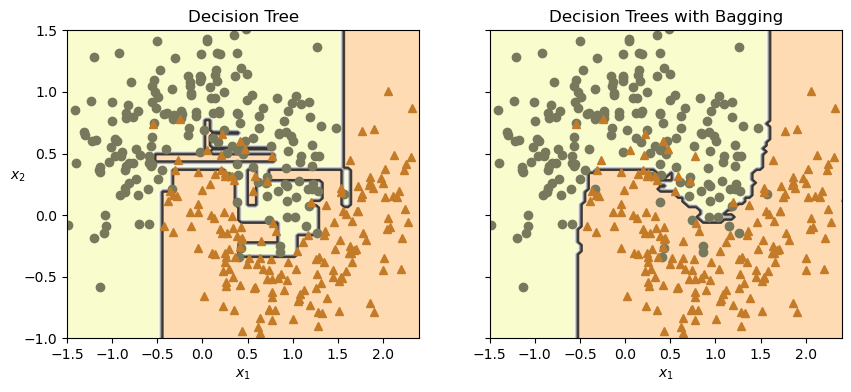

In [9]:
def plot_decision_boundary(clf, X, y, alpha=1.0):
    axes=[-1.5, 2.4, -1, 1.5]
    x1, x2 = np.meshgrid(np.linspace(axes[0], axes[1], 100),
                         np.linspace(axes[2], axes[3], 100))
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)

    plt.contourf(x1, x2, y_pred, alpha=0.3 * alpha, cmap='Wistia')
    plt.contour(x1, x2, y_pred, cmap="Greys", alpha=0.8 * alpha)
    colors = ["#78785c", "#c47b27"]
    markers = ("o", "^")
    for idx in (0, 1):
        plt.plot(X[:, 0][y == idx], X[:, 1][y == idx],
                 color=colors[idx], marker=markers[idx], linestyle="none")
    plt.axis(axes)
    plt.xlabel(r"$x_1$")
    plt.ylabel(r"$x_2$", rotation=0)

tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X_train, y_train)
plt.title("Decision Tree")
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X_train, y_train)
plt.title("Decision Trees with Bagging")
plt.ylabel("")
plt.show()

由于自举法给每个预测器的训练子集引入了更高的多样性，因此最后bagging比pasting的偏差略高，但这也意味着预测器之间的关联度更低，所以集成的方差降低。

总之，bagging生成的模型通常更好，所以bagging比pasting更受欢迎。

但是，如果有充足的时间和CPU资源，可以使用交叉验证来对bagging和pasting的结果进行评估，再做出最合适的选择。

### 包外评估

对于任意给定的预测器，使用bagging，有些训练实例可能会被采样多次，而有些实例则可能根本不被采样。

BaggingClassifier默认采样m个训练实例，然后放回样本(bootstrap=True)，m是训练集的大小。通过这个过程，可以从数学上表明，对每个预测器来说，平均只对63%的训练实例进行采样[。剩余37%未被采样的训练实例称为包外(Out Of Bag)实例。

注意，对所有预测器来说，这是不一样的37%。

bagging集成可以使用OOB实例进行评估，而不需要单独的验证集：实际上，如果有足够的估计器，那么训练集中的每个实例都可能是多个估计器的OOB实例，

因此可以使用这些估计器为该实例做出公平的集成预测。一旦对每个实例都有预测，就可以计算集成的预测精度（或任何其他指标）。

在sklearn中，创建BaggingClassifier时，设置oob_score=True，就可以请求在训练结束后自动进行包外评估。

下面的代码演示了这一点。通过变量oob_score_可以得到最终的评估分数：

In [10]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500,  oob_score=True, n_jobs=-1, random_state=42)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.896

In [11]:
# 正式测在测试集上的精度
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.92

In [12]:
# 每个训练实例的OOB决策函数也可通过oob_decision_function_属性获得。
# 由于基础估计器有一个predict_proba()方法，决策函数返回每个训练实例的类概率
bag_clf.oob_decision_function_[:3]

array([[0.32352941, 0.67647059],
       [0.3375    , 0.6625    ],
       [1.        , 0.        ]])

### 随机补丁和随机子空间

BaggingClassifier类也支持对特征进行采样。采样由两个超参数控制：max_features和bootstrap_features。

它们的工作方式与max_samples和bootstrap相同，但用于特征采样而不是实例采样。因此，每个预测器将用输入特征的随机子集进行训练。

当你处理高维输入（例如图像）时，此技术特别有用，因为它可以减少训练特征大大加快训练速度。

对训练实例和特征进行采样称为随机补丁方法。保留所有训练实例（通过设置bootstrap=False和max_samples=1.0）但对特征进行采样（通过将bootstrap_features设置为True或max_features为小于1.0的值）称为随机子空间方法。

对特征进行采样导致更多的预测多样性，用略高一点的偏差换取更低的方差。

## 随机森林

随机森林是决策树的集合，通常通过bagging方法（有时候pasting方法）进行训练，通常将max_samples设置为训练集的大小。

可以使用RandomForestClassifier类，而不是构建BaggingClassifier并将其传递给DecisionTreeClassifier

它更方便并且针对决策树进行了优化（类似地，有一个用于回归任务的RandomForestRegressor类）。

以下代码使用所有可用的CPU内核训练一个包含500棵树的随机森林分类器，每棵树最多有16个叶节点：

In [21]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_test)

RandomForestClassifier具有DecisionTreeClassifier的所有超参数（以控制树的生长方式），以及BaggingClassifier的所有超参数来控制集成本身。

随机森林算法在树的生长上引入了更多的随机性：拆分节点时不再搜索最好的特征，而是在一个随机生成的特征子集里搜索最好的特征。

默认情况下，才采样sqrt(n)个特征（n是特征的总个数）。

导致决策树具有更大的多样性，用更高的偏差换取更低的方差，总之，还是产生了一个整体性能更优的模型。

下面的BaggingClassifier与前面的RandomForestClassifier相同：

In [16]:
# 随堂练习： 根据刚才对原理的描述，通过BaggingClassifier 和 决策树， 生成和前面相同的RandomForestClassifier


### 极端随机树

随机森林里单棵树的生长过程中，每个节点在拆分时仅考虑了一个随机子集所包含的特征。

如果我们对每个特征使用随机阈值，而不是搜索得出的最佳阈值（如常规决策树所做的），则可能让决策树生长得更加随机

只需在创建DecisionTreeClassifier时设置splitter="random"。

这种极端随机的决策树组成的森林，被称为极端随机树集成。同样，它也是以更高的偏差换取了更低的方差。

极端随机树训练起来比常规随机森林要快很多，因为在每个节点上找到每个特征的最佳阈值是决策树生长中最耗时的任务之一。

可以使用Scikit-Learn的ExtraTreesClassifier类。它的API与RandomForest-Classifier类相同，除了bootstrap默认为False。同样，ExtraTreesRegressor类具有与RandomForestRegressor类相同的API，除了bootstrap默认为False。

通常来说，不一定预先知道一个RandomForestClassifier是否会比一个ExtraTreesClassifier更好或是更差。唯一的方法是两种都尝试一遍，然后使用交叉验证进行比较。

In [23]:
# 随堂练习：尝试使用ExtraTreesClassifier, 训练后在测试集上评估性能

### 特征重要性

随机森林的另一个好特性是，它们使测量每个特征的相对重要性变得容易。

sklearn通过查看使用该特征的树节点平均（在森林中的所有树上）减少杂质的程度来衡量该特征的重要性。

更准确地说，它是一个加权平均值，其中每个节点的权重等于与其关联的训练样本的数量

在 **RandomForestClassifier**里特征重要性是通过 **平均减少杂质**（Mean Decrease in Impurity, MDI）来衡量的。

核心思想：

* 如果一个特征在分裂数据时，能显著减少节点的不纯度（impurity），那么它对模型预测的贡献就越大。
* 计算时会考虑 **该分裂节点覆盖的样本数**，因为分裂一个样本数很多的节点影响更大。

计算步骤：

1. **计算节点的不纯度（Impurity）**
   常用 Gini 指数或熵：

   * **Gini**（二分类）：

     $$
     G(t) = 1 - p_0^2 - p_1^2
     $$

     其中 $p_k$ 是节点中类别 $k$ 的比例。
   * **熵**（Entropy）：

     $$
     H(t) = - \sum_k p_k \log_2 p_k
     $$

2. **计算该节点分裂带来的杂质减少量（Impurity Decrease）**
   对于节点 $t$，设：

   * $N_t$：到达节点 $t$ 的样本数
   * $I(t)$：该节点的不纯度
   * 左子节点 $t_L$ 样本数 $N_L$，不纯度 $I(t_L)$
   * 右子节点 $t_R$ 样本数 $N_R$，不纯度 $I(t_R)$
     那么：

   $$
   \Delta I_t = I(t) - \frac{N_L}{N_t} I(t_L) - \frac{N_R}{N_t} I(t_R)
   $$

3. **加权节点的重要性贡献**
   sklearn 会用 **样本数权重**来放大重要性：

   $$
   \text{contribution}_t = N_t \times \Delta I_t
   $$

   这样一个大节点的分裂（即使 impurity decrease 不算特别大）也能体现出它的重要性。

4. **汇总每个特征的贡献**
   对森林中所有树的所有节点，凡是用特征 $j$ 分裂的，累计它们的 contribution：

   $$
   \text{score}_j = \sum_{\text{nodes split on } j} N_t \times \Delta I_t
   $$

5. **归一化**
   把所有特征的 score 相加得到总和 $S$，然后：

   $$
   \text{importance}_j = \frac{\text{score}_j}{S}
   $$

   这样所有特征的重要性之和等于 1。

Scikit-Learn会在训练后为每个特征自动计算该分数，然后对结果进行缩放以使所有重要性的总和等于1。

可以使用feature_importances_变量来访问结果。例如，以下代码在鸢尾花数据集上训练了RandomForestClassifier，并输出每个特征的重要性。看起来最重要的特征是花瓣长度(44%)和宽度(42%)，而花萼的长度和宽度则相对不那么重要（分别是11%和2%)

In [24]:
from sklearn.datasets import load_iris
iris = load_iris(as_frame=True)
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(iris.data, iris.target)

for score, name in zip(rnd_clf.feature_importances_, iris.data.columns):
    print(round(score, 2), name)

0.11 sepal length (cm)
0.02 sepal width (cm)
0.44 petal length (cm)
0.42 petal width (cm)


同样，如果在MNIST数据集上训练随机森林分类器，并绘制每个像素的重要性。

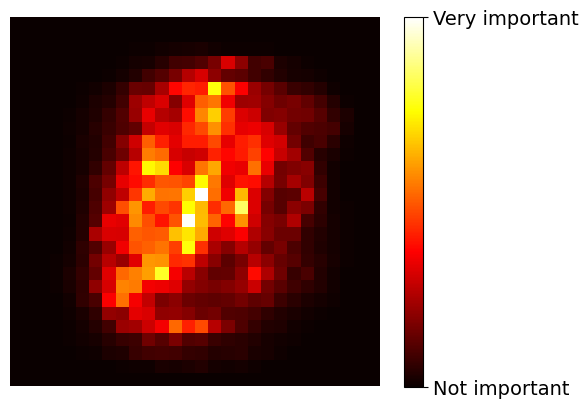

In [25]:
from sklearn.datasets import fetch_openml

X_mnist, y_mnist = fetch_openml('mnist_784', return_X_y=True, as_frame=False,
                                parser='auto')

rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(X_mnist, y_mnist)

heatmap_image = rnd_clf.feature_importances_.reshape(28, 28)
plt.imshow(heatmap_image, cmap="hot")
cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(),
                           rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'], fontsize=14)
plt.axis("off")
plt.show()

## 提升法

提升法（boosting)是指可以将几个弱学习器结合成一个强学习器的任意集成方法。

大多数提升法的总体思路是循环训练预测器，每一次都对其前序做出一些改成。

bbb### AdaBoost

新预测器对其前序进行纠正的办法之一，就是更多地关注前序欠拟合的训练实例。从而使新的预测器不断地越来越专注于难缠的问题，这就是AdaBoost使用的技术。

例如，当训练AdaBoost分类器时，该算法首先训练一个基础分类器（例如决策树），并使用它对训练集进行预测。然后，该算法会增加分类错误的训练实例的相对权重。之后，它使用更新后的权重训练第二个分类器，并再次对训练集进行预测，更新实例权重，以此类推